In [1]:
%reload_ext autoreload
%autoreload 2
import tensorflow as tf
import sys
import math
import numpy as np
sys.path.append('../../pytools')
import d2l

d2l.gpu_mem_init()

2026-02-06 15:45:20.572903: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-02-06 15:45:20.634621: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-02-06 15:45:22.133137: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


Memory growth enabled for PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'): True


In [2]:
class Residual(tf.keras.Model):
    def __init__(self, num_channels, use_conv2d1x1=False, strides=1):
        super().__init__()
        self.conv1 = tf.keras.layers.Conv2D(num_channels, kernel_size=3, padding='same', strides=strides)
        self.conv2 = tf.keras.layers.Conv2D(num_channels, kernel_size=3, padding='same')
        self.conv3 = None
        if use_conv2d1x1:
            self.conv3 = tf.keras.layers.Conv2D(num_channels, kernel_size=1, strides=strides)
        self.bn1 = tf.keras.layers.BatchNormalization()
        self.bn2 = tf.keras.layers.BatchNormalization()
    def call(self, input):
        y = tf.keras.activations.relu(self.bn1(self.conv1(input))) 
        y = self.bn2(self.conv2(y))
        if self.conv3 is not None:
            input = self.conv3(input)
            
        y += input
        return tf.keras.activations.relu(y)



In [3]:
blk = Residual(3)
X = tf.random.uniform((4, 6, 6, 3))
Y = blk(X)
Y.shape

I0000 00:00:1770363923.299662 3184875 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5054 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:08.0, compute capability: 7.5
2026-02-06 15:45:24.110305: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91002


TensorShape([4, 6, 6, 3])

In [4]:
class ResnetBlock(tf.keras.layers.Layer):
    def __init__(self, num_channels, num_residuals, first_block=False, **kwargs):
        super(ResnetBlock, self).__init__(**kwargs)
        self.residual_layers = []
        for i in range(num_residuals):
            if i == 0 and not first_block:
                self.residual_layers.append(Residual(num_channels, use_conv2d1x1=True, strides=2))
            else:
                self.residual_layers.append(Residual(num_channels))
    def call(self, X):
        for layer in self.residual_layers:
            X = layer(X)
        return X

In [5]:
def net():
    return tf.keras.Sequential([
        tf.keras.layers.Conv2D(64, kernel_size=7, strides=2, padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding='same'),
        ResnetBlock(64, 2, first_block=True),
        ResnetBlock(128, 2),
        ResnetBlock(256, 2),
        ResnetBlock(512, 2),
        tf.keras.layers.GlobalAvgPool2D(),
        tf.keras.layers.Dense(units=10)])

In [6]:
X = tf.random.uniform(shape=(1, 224, 224, 1))
for layer in net().layers:
    X = layer(X)
    print(layer.__class__.__name__,'output shape:\t', X.shape)

Conv2D output shape:	 (1, 112, 112, 64)
BatchNormalization output shape:	 (1, 112, 112, 64)
Activation output shape:	 (1, 112, 112, 64)
MaxPooling2D output shape:	 (1, 56, 56, 64)
ResnetBlock output shape:	 (1, 56, 56, 64)
ResnetBlock output shape:	 (1, 28, 28, 128)
ResnetBlock output shape:	 (1, 14, 14, 256)
ResnetBlock output shape:	 (1, 7, 7, 512)
GlobalAveragePooling2D output shape:	 (1, 512)
Dense output shape:	 (1, 10)


loss 0.105, train acc 0.963, test acc 0.797
1117.4 examples/sec on /GPU:0
INFO:tensorflow:Assets written to: /home/ubuntu/work/data/resnet/saved_model/assets


INFO:tensorflow:Assets written to: /home/ubuntu/work/data/resnet/saved_model/assets


Saved artifact at '/home/ubuntu/work/data/resnet/saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 96, 96, 1), dtype=tf.float32, name='keras_tensor_15')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  140144303915600: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140144303963680: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140143509170560: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140144303928096: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140144303830144: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140144303920000: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140143509163344: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140144303917712: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140143509161760: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140143509172672: TensorSpec(shape=(), dtype=tf.resource, 

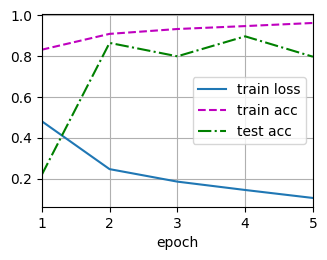

In [7]:
lr, num_epochs, batch_size = 0.05, 5, 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=96)
res_net18 = d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())
res_net18.export("/home/ubuntu/work/data/resnet/saved_model")

In [8]:
#TODO 推导每一层的参数数量
print(res_net18.summary())

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_22 (Conv2D)              │ (256, 48, 48, 64)      │         3,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (256, 48, 48, 64)      │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (256, 48, 48, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (256, 24, 24, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet_block_4 (ResnetBlock)    │ (256, 24, 24, 64)      │       148,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet_block_5 (ResnetBlock)    │ (256, 12, 12, 128)     │       526,976 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet_block_6 (ResnetBlock)    │ (256, 6, 6, 256)       │     2,102,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet_block_7 (ResnetBlock)    │ (256, 3, 3, 512)       │     8,399,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (256, 512)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (256, 10)              │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,186,188 (42.67 MB)

 Trainable params: 11,178,378 (42.64 MB)

 Non-trainable params: 7,808 (30.50 KB)

 Optimizer params: 2 (12.00 B)

None
